In [1]:
import numpy as np
from sklearn import metrics 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import deepchem as dc
from tensorflow import keras
import joblib
from deepchem.utils.save import load_from_disk
from deepchem.models.sklearn_models import SklearnModel

sns.set()


## Keras model - binarised representation

keras_bin = keras.models.load_model("keras_from_mat_sgd_0.001_400_100_18072019.h5")

## Keras model - eigenspectrum representation

keras_eig = keras.models.load_model("keras_from_mat_eigenspectrum_23072019.h5")

## KRR model - binarised representation

krr_bin = joblib.load(open("krr_binarised_laplacian_24072019.sav", "rb"))

## KRR model - eigenspectrum representation 

krr_eig = joblib.load(open("krr_eig_laplacian_24072019.sav", "rb"))


models = {}
models['keras_bin'] = [keras_bin]
models['keras_eig'] = [keras_eig]
models['krr_bin'] = [krr_bin]
models['krr_eig'] = [krr_eig]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [2]:
## Load data set

dataset_file = "raw_data/gdb7.sdf"

tasks = ["u0_atom"]

## Raw dataset
featurizer = dc.feat.CoulombMatrix(max_atoms=23)

loader = dc.data.SDFLoader(
  tasks=['u0_atom'],
  smiles_field="smiles",
  mol_field="mol",
  featurizer=featurizer)

## Eigenvector dataset
dataset = loader.featurize(dataset_file)

eig_featurizer = dc.feat.CoulombMatrixEig(23, remove_hydrogens=False)

data_loader_eig = dc.data.SDFLoader(
      tasks=["u0_atom"], smiles_field="smiles",
      featurizer=eig_featurizer,
      mol_field="mol")

dataset_eig = data_loader_eig.featurize(dataset_file)


Loading raw samples now.
shard_size: 8192
Reading structures from raw_data/gdb7.sdf.
Currently featurizing feature_type: CoulombMatrix
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 3.555 s
TIMING: dataset construction took 5.494 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
Reading structures from raw_data/gdb7.sdf.
Currently featurizing feature_type: CoulombMatrixEig
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 5.098 s
TIMING: dataset construction took 6.556 s
Loading dataset from disk.


In [3]:
def split_transformer(splitter, trans_func, dataset):
    train, valid, test = splitter.train_valid_test_split(dataset)
    if trans_func == 'normaliser':
        normaliser = dc.trans.NormalizationTransformer(transform_X=True, dataset=train, move_mean=True)
        train, valid, test = (normaliser.transform(train), normaliser.transform(valid), normaliser.transform(test))
        print("normalised train: ", train.X[0])
    elif trans_func == 'binariser':
        binariser = dc.trans.CoulombFitTransformer(dataset=train)
        train, valid, test = (binariser.transform(train), binariser.transform(valid), binariser.transform(test))
        print("binased train: ", train.X[0])
    print("returned train: ", train.X[0])
    return train, valid, test

In [4]:
## Split and transform datasets

splitter = dc.splits.SingletaskStratifiedSplitter(task_number=0)

train_eig, valid_eig, test_eig = split_transformer(splitter, 'normaliser', dataset_eig)
train_bin, valid_bin, test_bin = split_transformer(splitter, 'binariser', dataset)

print(train_eig.get_shape())
print(train_bin.get_shape())


TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.034 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/trans/transformers.py:148: RuntimeWarning: divide by zero encountered in true_divide
  X = np.nan_to_num((X - self.X_means) / self.X_stds)
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/trans/transformers.py:148: RuntimeWarning: invalid value encountered in true_divide
  X = np.nan_to_num((X - self.X_means) / self.X_stds)


TIMING: dataset construction took 0.061 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
normalised train:  [-1.1351866  -3.08033544 -6.20500294 -6.72806288 -7.26998732 -5.28979259
 -2.29389992 -3.02521413 -6.72814671 -5.38843971 -4.15919107 -3.4065704
 -2.41143573 -1.72445238 -1.35154592 -0.95166217 -0.76104596 -0.52347132
 -0.39417538 -0.25240125 -0.14911338 -0.07371591  0.        ]
returned train:  [-1.1351866  -3.08033544 -6.20500294 -6.72806288 -7.26998732 -5.28979259
 -2.29389992 -3.02521413 -6.72814671 -5.38843971 -4.15919107 -3.4065704
 -2.41143573 -1.72445238 -1.35154592 -0.95166217 -0.76104596 -0.52347132
 -0.39417538 -0.25240125 -0.14911338 -0.07371591  0.        ]
TIMING: dataset construction took 0.390 s
Loading dataset from disk.
TIMING: dataset construction took 0.182 s
Loading dataset from disk.
TIMING: dataset construction took 0.181 s
Loading dataset f

In [9]:
## Test data 
X_test = test_eig.X
y_test = test_eig.y

X_bin_test = test_bin.X[:, :2089]
y_bin_test = test_bin.y[:, :2089]

keras_bin_pred = models['keras_bin'][0].predict(X_bin_test)
predictions = pd.DataFrame(keras_bin_pred, columns=['keras_bin'])
predictions['krr_bin'] = models['krr_bin'][0].predict(X_bin_test) 
predictions['keras_eig'] = models['keras_eig'][0].predict(X_test)
predictions['krr_eig']  = models['krr_eig'][0].predict(X_test)



In [10]:
# Error analysis

errors = {}

for model in models:
    if 'bin' in model:
        errors[model] = {'mae': metrics.mean_absolute_error(y_bin_test, predictions[model]), 
                        'mse': np.sqrt(metrics.mean_squared_error(y_bin_test, predictions[model]))}
    else:
        errors[model] = {'mae': metrics.mean_absolute_error(y_test, predictions[model]), 
                        'mse': np.sqrt(metrics.mean_squared_error(y_test, predictions[model]))}


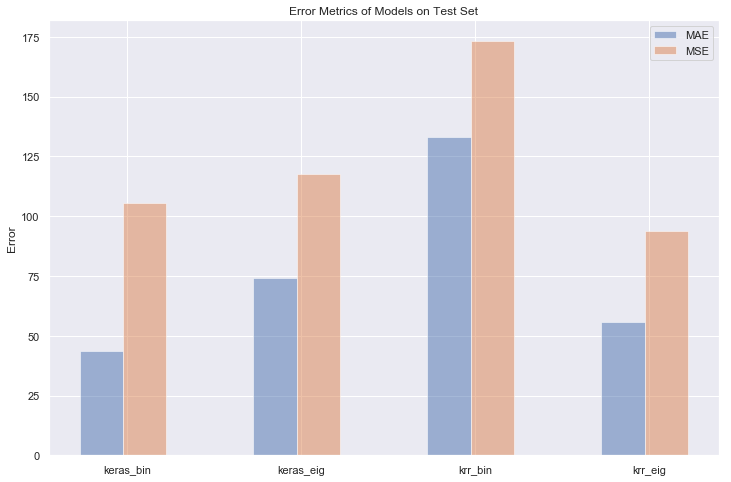

In [11]:

pos = [0,1,2,3]
width = 0.25

fig, ax = plt.subplots(figsize=(12,8))

plt.bar(pos, 
        [errors[model]['mae'] for model in errors], 
        width, 
        alpha=0.5, 
        label='MAE') 

plt.bar([p+width for p in pos], 
        [errors[model]['mse'] for model in errors], 
        width, 
        alpha=0.5, 
        label='MsE') 

ax.set_ylabel('Error')
ax.set_title('Error Metrics of Models on Test Set')
ax.set_xticks([p + 0.15 for p in pos])
ax.set_xticklabels(['keras_bin', 'keras_eig', 'krr_bin', 'krr_eig'])
ax.legend(['MAE', 'MSE'])
plt.show()

